Pipe_ID – identyfikator rury (unikalny numer, np. P-1861).

Pressure_PSI – ciśnienie wody w rurze (PSI – funty na cal kwadratowy).

Flow_GPM – przepływ wody (GPM – gallons per minute, galonów na minutę).

Velocity_FPS – prędkość przepływu wody (feet per second, stopy na sekundę).

Temperature_F – temperatura wody (°F).

Pipe_Age_Years – wiek rury w latach.

Pipe_Material – materiał rury (np. PVC, HDPE, Steel).

Soil_Corrosivity – korozyjność gleby w miejscu instalacji (Low, Medium, High).

Leak_Class – klasa wycieku / awarii:

0 = brak wycieku (OK)
1 = wykryty wyciek / awaria

In [ ]:
# ========================
# 1. Import bibliotek
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import pickle


In [2]:
# ========================
# 2. Wczytanie danych
# ========================
data_path = "../data/raw/water_network_leak_dataset.xlsx"
df = pd.read_excel(data_path)

print("Podgląd danych:")
display(df.head())

Podgląd danych:


,Pipe_ID,Pressure_PSI,Flow_GPM,Velocity_FPS,Temperature_F,Pipe_Age_Years,Pipe_Material,Soil_Corrosivity,Leak_Class
0,P-1861,38.7,206.4,8.0,77,10,PVC,Low,1
1,P-354,64.2,89.5,4.2,66,3,HDPE,Low,0
2,P-1334,72.5,118.6,4.8,80,6,HDPE,Medium,0
3,P-906,65.2,121.3,3.3,76,4,Steel,High,0
4,P-1290,54.2,105.7,3.9,56,4,Steel,Low,0


In [3]:
# ========================
# 3. Preprocessing
# ========================
# Label encoding dla kolumn kategorycznych
le_material = LabelEncoder()
le_soil = LabelEncoder()

In [4]:
df["Pipe_Material"] = le_material.fit_transform(df["Pipe_Material"])
df["Soil_Corrosivity"] = le_soil.fit_transform(df["Soil_Corrosivity"])


In [5]:
# Feature (X) i target (y)
X = df.drop(columns=["Pipe_ID", "Leak_Class"])
y = df["Leak_Class"]

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
# ========================
# 4. Model Random Forest
# ========================
model = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight="balanced"
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00        80

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



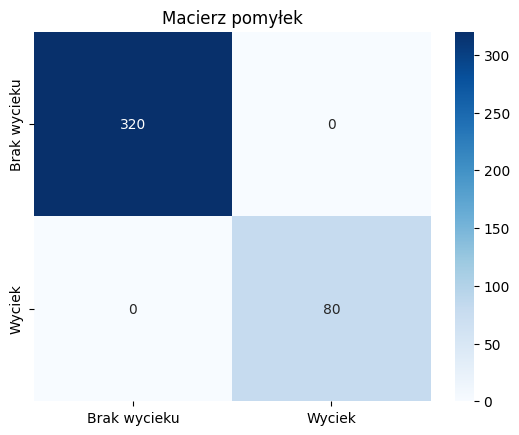

In [7]:
# ========================
# 5. Ewaluacja
# ========================
y_pred = model.predict(X_test)

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Brak wycieku", "Wyciek"],
            yticklabels=["Brak wycieku", "Wyciek"])
plt.title("Macierz pomyłek")
plt.show()

In [8]:
# ========================
# 6. Ważność cech (Feature Importance)
# ========================
importances = model.feature_importances_
features = X.columns
fi_df = pd.DataFrame({"Feature": features, "Importance": importances})
fi_df = fi_df.sort_values("Importance", ascending=False)

fig = px.bar(fi_df, x="Importance", y="Feature", orientation="h",
             title="Najważniejsze czynniki ryzyka awarii")
fig.show()


In [12]:
# ========================
# 7. Predykcja z ryzykiem (efekt WOW)
# ========================
sample = df.sample(20, random_state=42).copy()
sample_features = sample.drop(columns=["Pipe_ID", "Leak_Class"])

# Prawdopodobieństwo wycieku
sample["Ryzyko (%)"] = model.predict_proba(sample_features)[:, 1] * 100

# Kolory ryzyka
def risk_level(p):
    if p > 70: return "🔴 Wysokie ryzyko"
    elif p > 40: return "🟡 Średnie ryzyko"
    else: return "🟢 Niskie ryzyko"

sample["Ocena_modelu"] = sample["Ryzyko (%)"].apply(risk_level)

display(sample[["Pipe_ID", "Pressure_PSI", "Flow_GPM",
                "Pipe_Age_Years", "Ryzyko (%)", "Ocena_modelu"]])

,Pipe_ID,Pressure_PSI,Flow_GPM,Pipe_Age_Years,Ryzyko (%),Ocena_modelu
1860,P-1523,63.9,95.5,5,0.0,🟢 Niskie ryzyko
353,P-1611,37.1,221.0,18,99.5,🔴 Wysokie ryzyko
1333,P-569,55.6,122.9,1,0.0,🟢 Niskie ryzyko
905,P-1802,39.4,172.0,17,100.0,🔴 Wysokie ryzyko
1289,P-091,65.5,114.9,6,0.0,🟢 Niskie ryzyko
1273,P-1775,32.6,166.9,11,100.0,🔴 Wysokie ryzyko
938,P-334,61.6,104.6,2,0.0,🟢 Niskie ryzyko
1731,P-220,65.4,106.3,3,0.0,🟢 Niskie ryzyko
65,P-1848,31.3,206.1,28,100.0,🔴 Wysokie ryzyko
1323,P-1633,33.6,212.9,22,100.0,🔴 Wysokie ryzyko


Wysokie ciśnienie → rura jest poddana dużym obciążeniom.

Wiek rury → stara rura (np. 28–29 lat) ma większe ryzyko pęknięcia.

Materiał + gleba → np. stal w glebie o wysokiej korozyjności = duże prawdopodobieństwo awarii.

Przepływ / prędkość → nienaturalnie wysokie wartości → możliwa anomalia.

System wykrył, że rura P-1848 ma 28 lat, znajduje się w glebie o podwyższonej korozyjności i pracuje przy dużym przepływie. To powoduje, że jej ryzyko awarii oceniamy na 100%.”

„Rura P-1611 jest stosunkowo młodsza, ale działa przy bardzo niskim ciśnieniu (anomalia) i wysokim przepływie, co sugeruje wyciek.”

Niska ryzyko (np. 0%) → „Rura P-1523 ma tylko 5 lat, jest z PVC i działa przy stabilnym ciśnieniu. Model uznał, że jej ryzyko awarii to 0%.”

Wysokie ryzyko (np. 100%) → „Rura P-1963 ma 29 lat, stalowa, duży przepływ i wysokie ciśnienie. To typowy kandydat do awarii.”

In [15]:
with open("../data/processed/model.pkl", "wb") as f:
    pickle.dump(model, f)